In [1]:
# Task:
# Turn data into "images"
# Two networks
# GAN: generate atoms and bonds (adjacency) layers
# simple CNN: turning SMILES layer to atoms+bonds layers

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from numpy import ndarray
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

# loading SMILES data using Chainer Chemistry
from chainer_chemistry.datasets.molnet import get_molnet_dataset
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset
from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor, construct_atomic_number_array

# import necessary libraries
import os
import glob

from rdkit import Chem

# import general file from utils as shared packages
import sys
sys.path.append("./../utils/")
from general import *

2023-05-29 21:02:44.661833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 21:02:44.733886: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-29 21:02:45.081439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64:
2023-05-29 21:02:45.081491: W tensorflow/compile

In [2]:
# use glob to get all the csv files 
# in the folder
path = './../data/trainingsets/highgap_outliergen_trans1/dft_evaluated/'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
data_gen = pd.DataFrame({})
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f)
    data_gen = pd.concat((data_gen, df), axis=0)
    # print the location and filename
    #print('Location:', f)
    print('File Name:', f.split("\\")[-1])

File Name: ./../data/trainingsets/highgap_outliergen_trans1/dft_evaluated/DFT_gap_1000_batch1_Bhupalee.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/dft_evaluated/gap_larg9p5_dft.csv
File Name: ./../data/trainingsets/highgap_outliergen_trans1/dft_evaluated/DFT_gap_1000_2ndbatch.csv


In [3]:
"""Chem.MolFromSmiles('CC1CC(O)C2(CC2)O1')"""

preprocessor = GGNNPreprocessor()
#atom_num = construct_atomic_number_array()
#data_gen = pd.read_csv('./outliers17.csv')
data_gen0 = data_gen.copy()

gen_smiles = []
idx = []
for i, smile in enumerate(data_gen['SMILES']):
    try:
        gen_smiles.append (Chem.MolToSmiles(Chem.MolFromSmiles(smile, sanitize=True), canonical=True))
        idx.append(i)
    except:
        print (smile)
        pass
idx = np.array(idx)
data_gen = data_gen.iloc[idx]
data_gen = data_gen.reset_index(drop=True)

In [4]:

print ('Test all gen smiles are canonical:', 
       sum(gen_smiles==data_gen['SMILES'])==data_gen.shape[0])
print (gen_smiles[0])


data_gen = data_gen.drop_duplicates(subset=['SMILES'], keep='first').reset_index(drop=True)

gen_smiles = data_gen['SMILES']
try:
    DFT_gap = data_gen['DFT_gap']
except:
    DFT_gap = data_gen['pred_gap']

Test all gen smiles are canonical: False
CCCOCC1CCC(CCCCCCCCC(C)C)C1


In [5]:
sum(gen_smiles==data_gen['SMILES'])==data_gen.shape[0]

True

In [9]:
# use glob to get all the csv files from previous generation
# put the previous files in the same folder
path = './../data/trainingsets/highgap_outliergen_trans1/'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
data_gen_previus = pd.DataFrame({})
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f)
    data_gen_previus = pd.concat((data_gen_previus, df), axis=0)
    # print the location and filename
    #print('Location:', f)
    print('File Name:', f.split("\\")[-1])

In [10]:
data_gen = data_gen.reset_index(drop=True)

In [11]:
data_gen_previus

""


In [12]:
data_gen.loc[data_gen['DFT_gap']>11]

,SMILES,DFT_gap
1915,CCC(C)(C)C(F)(F)F,11.023337
1916,C1C2CC1C2,11.036943
1917,CC(C)C(C)C(F)(F)F,11.055992
1918,CCCCCC(F)(F)F,11.085924
1919,CCCC(C)C(F)(F)F,11.124021
1920,CCCC,11.175721
1921,FC(F)(F)C12CC(C1)C2,11.181164
1922,CC(C)CC(F)(F)F,11.202933
1923,CCC(CC)C(F)(F)F,11.232866
1924,FC(F)(F)C1C2CC1C2,11.292730


In [9]:
# find the repetitives from train
#previous_rep = pd.merge(data_gen, data_gen_previus, on = 'SMILES', how = 'inner')
#print ("Same generated SMILES compared to pubqc: \n{}".format(previous_rep))

In [10]:
"""
rep_smiles = previous_rep['SMILES']
for i in range(data_gen.shape[0]):
    if (data_gen['SMILES'].loc[i] in list(rep_smiles)):
        print (i)
        data_gen = data_gen.drop(i)
"""

"\nrep_smiles = previous_rep['SMILES']\nfor i in range(data_gen.shape[0]):\n    if (data_gen['SMILES'].loc[i] in list(rep_smiles)):\n        print (i)\n        data_gen = data_gen.drop(i)\n"

In [13]:
data_gen = data_gen.drop_duplicates(subset=['SMILES'], keep='first').reset_index(drop=True)

gen_smiles = data_gen['SMILES']
try:
    DFT_gap = data_gen['DFT_gap']
except:
    DFT_gap = data_gen['pred_gap']

In [14]:
print (data_gen.shape)
print (len(gen_smiles))
print (len(DFT_gap))

(2871, 2)
2871
2871


<Axes: xlabel='DFT_gap', ylabel='Count'>

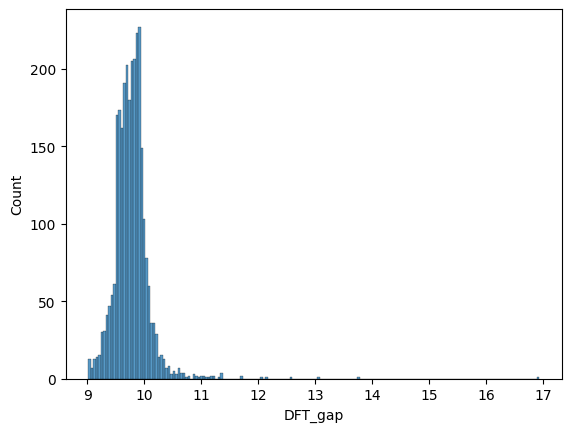

In [15]:
sns.histplot (data_gen['DFT_gap'])

In [16]:
with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer_object.pickle', 'rb') as f:
    tokenizer_ = pickle.load(f)

with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

In [17]:
X_smiles = []
for smile in gen_smiles:
    print (smile)
    m  = Chem.MolFromSmiles(smile, sanitize=True)
    smiles_can = Chem.MolToSmiles(m, canonical=True)
    smiles_can_dot = smiles_can + '.'
    X_smiles0 = tokenizer_.texts_to_sequences([smiles_can_dot])
    X_smiles1 = pad_sequences(X_smiles0, maxlen = 40, padding = 'post')
    X_smiles2 = to_categorical(X_smiles1, num_classes=27)
    SHAPE = list(X_smiles2.shape[1:])+[1]
    X_smiles2 = X_smiles2.reshape(SHAPE)
    X_smiles.append(X_smiles2)

CCCOCC1CCC(CCCCCCCCC(C)C)C1
CCCCC(C)CC1(CC)CC1C
CCCCCCCC(F)CCCOC(C)C
CCCC1CC1C1C(C)C1CC
CCCCCCCC1CC1CC(CCC)C(C)CC
CC1CCCCCC(C)(CC(C)(C)C)CC1
COCC(C)CCCCCCC(C)C
CC1CCCC(C)C(C)CCC1C
CCC1CC1C(C)CC1CCCC1C
CC1CCCCCCCCCCCCCC(C2CC2)C1
CCCCCCC(CC)C1C(C)C1CC
CCC(C)CC(C)CC1CC1C(CC)CC
CC1CC2CCCCCCC1C1CCCCCC1CC2
CCCCCC1CC(C)CCCC1(CCC)CCC
CC(C)CCCCCCCC1CC1(C)C
CC1CCCC(CC2CC2C)C1
CCCC12CCCCCCC1C(CC)C2
CCC(CCCCC(C)C)CC1C(C)C1CC
CC1CCCCC(C)C2CCC(C(C)C)CCC2C1
CCC(C)CCCCCCC1CCCCC1C
CCCCCCCCC1CCCCCCC(C2CC2)C1
CCCCCCC1C(C)C1CCCCC(C)C
CCCCC1CC(C)CCCC(C)C(CC)C1
CCCCC1C2CCCC1CC(CC)C2
CC(C)C1CC1C1CCCC1
CC(C)CCCC1CC1C1CCC1C
CCCCC.CCCCCCC(CC(C)C)CC(C)C
CCCCCCCCC1C(CCCC)CC1CCCC
CCCCCCCCC1C(C)CC1CCCC
CCCC1CCCCC1C1CCCCC(C)CC1CCC
CCCCCCCC1CC1CCC(C)CC(C)CC
CCCCC(C)CC1CCCC(CC(CC)CC)C1
CCCCCCCCC1CCCCCCCCC1CCC
CCCCCCCC(CCC)CC1(CC)CCCCC1
CC1CCCCCC(CC2CCCC(C)C2)CCC1
CC1CCCCCCC2CCC(CCCCC2C)CCC1
CC1CCCCC(CCC2CCC(C)C2)CCC1
CCCCCCCCCC1C(C)CCCCCCC1CCC
CC(C)C1C(C)CCCC1(C)C
CCCC1CCC(C)CCCCC1C
CCCCCCC1CC1C(C)CC(C)CC
CC1CCC(C)C2C

In [18]:
X_smiles = np.array (X_smiles)

In [19]:
X_smiles.shape

(2871, 40, 27, 1)

<Axes: xlabel='DFT_gap', ylabel='Count'>

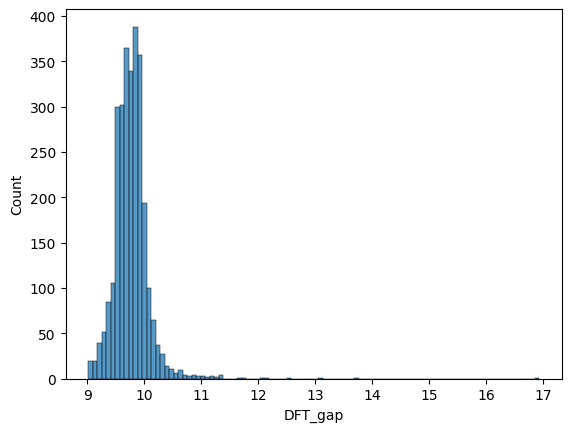

In [20]:
sns.histplot (DFT_gap, bins=100)

In [21]:
#val_accurate.to_csv('gen_new_noscreen_all_joback.csv', index = False)
preprocessor = GGNNPreprocessor()

with open('./../data/trainingsets/image.pickle', 'rb') as f:
    X_smiles_pubqc, SMILES_pubqc, gap_pubqc = pickle.load(f)
    
with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '

with open('./../data/trainingsets/train_regular_pubqc130K/tokenizer_object.pickle', 'rb') as f:
    tokenizer_ = pickle.load(f)

In [22]:
# save as canonical SMILES to find duplicates
# the gen smiles already converted to Canonical
SMILES_pubqc_can = []
for s in SMILES_pubqc:
    try:
        m = Chem.MolFromSmiles (s[:-1])
        ss = Chem.MolToSmiles(m)
        SMILES_pubqc_can.append(ss)
    except Exception as error:
        print (error)
#SMILES = SMILES.astype('str')
print ('First SMILES in pubqc', SMILES_pubqc[0])
print (np.array(SMILES_pubqc).shape)
print (SMILES_pubqc.shape)
SMILES_pubqc_can = np.array(SMILES_pubqc_can)
data_pubqc = {}
data_pubqc ['SMILES'] = SMILES_pubqc_can
data_pubqc ['gap'] = gap_pubqc
data_pubqc = pd.DataFrame(data_pubqc)

First SMILES in pubqc Nc1nc[nH]c2ncnc1-2.
(132626,)
(132626,)


In [27]:
data_pubqc [gap_pubqc>10.5]

,SMILES,gap
32396,CCCCCCCC,10.653000
32397,N#N,10.961000
32398,C1CC1,10.700000
32399,CC(C)C,10.985000
32400,CCC(C)C,10.757000
32401,CCCC(C)C,10.664000
32402,CCCCCC,10.806000
32403,C1CCC1,10.602000
32404,C1CCCC1,10.740000
32405,CC(C)(C)C,10.626000


In [28]:
# find the repetitives from train
database_samples_rep = pd.merge(data_gen, data_pubqc, on = 'SMILES', how = 'inner')
print ( "Same generated SMILES compared to pubqc: \n{}".format(database_samples_rep))

Same generated SMILES compared to pubqc: 
              SMILES    DFT_gap     gap
0      CC(C)CCCC1CC1   9.502215   9.698
1       CC1CC(C)OCO1   9.502221   9.208
2    CCC1(CC)CC(C)C1   9.502221   9.554
3    CCC1(C(C)C)CCC1   9.502221   9.478
4        CCCC1CCOCO1   9.502221   9.527
..               ...        ...     ...
499           C1CCC1  10.715849  10.602
500       CC1C2CC1C2  10.718571  10.781
501           CCCCCC  10.767550  10.806
502     C1C2C3CC2C13  10.770271  10.901
503           CC(C)C  10.911771  10.985

[504 rows x 3 columns]


In [33]:
gen_smiles

0       CCCOCC1CCC(CCCCCCCCC(C)C)C1
1               CCCCC(C)CC1(CC)CC1C
2              CCCCCCCC(F)CCCOC(C)C
3                CCCC1CC1C1C(C)C1CC
4         CCCCCCCC1CC1CC(CCC)C(C)CC
                   ...             
2866               CCC(C)CC(C)C(C)F
2867               CCCCCCCCC(F)CCCC
2868           CCC(CC)C(F)(F)CC(C)C
2869            CC(C)CCCCCCC(C)(F)F
2870          CCC(C)CCCC(C)C(F)(F)F
Name: SMILES, Length: 2871, dtype: object

In [34]:
DFT_gap

0        9.018129
1        9.036633
2        9.050782
3        9.073096
4        9.085613
          ...    
2866    10.224954
2867    10.225771
2868    10.253254
2869    10.275567
2870    10.341963
Name: DFT_gap, Length: 2871, dtype: float64

In [31]:
rep_smiles = database_samples_rep['SMILES']
rep_idx = []
for i in range(gen_smiles.shape[0]):
    if (gen_smiles[i] in list(rep_smiles)):
        #print (i)
        rep_idx.append(i)

In [32]:
idx = np.setdiff1d(list(range(len(gen_smiles))), rep_idx)
idx.shape

(2367,)

In [35]:
# if do not want to remove the replicates
X_smiles_norep = X_smiles.copy()
gen_smiles_norep = gen_smiles.copy()
DFT_gap_norep = DFT_gap.copy()

# if you want to remove the replicates
"""
X_smiles_norep = X_smiles[idx]
gen_smiles_norep = gen_smiles[idx]
DFT_gap_norep = DFT_gap[idx]
"""

'\nX_smiles_norep = X_smiles[idx]\ngen_smiles_norep = gen_smiles[idx]\nDFT_gap_norep = DFT_gap[idx]\n'

In [36]:
gen_smiles_norep = gen_smiles_norep.reset_index(drop=True)
DFT_gap_norep = DFT_gap_norep.reset_index(drop=True)


In [37]:
gen_smiles0 = []
for smile in gen_smiles_norep:
    s_dot = smile + '.'
    gen_smiles0.append(s_dot)
gen_smiles0 = np.array(gen_smiles0)

In [38]:
SMILES_nodot = []
for i in gen_smiles0:
    smile = i[:-1]
    SMILES_nodot.append(smile)
SMILES_nodot = np.array (SMILES_nodot)

In [39]:
# subsampling
np.random.seed(420)
idx = np.random.choice(len(DFT_gap_norep), int(len(DFT_gap_norep) * 0.8), replace = False)
X_smiles_train, SMILES_train, y_train = (X_smiles_norep[idx], 
                                         gen_smiles0[idx], 
                                         DFT_gap_norep[idx])

idx_test = np.setdiff1d(list(range(len(DFT_gap_norep))), idx)
X_smiles_test, SMILES_test, y_test = (X_smiles_norep[idx_test], 
                                      gen_smiles0[idx_test], 
                                      DFT_gap_norep[idx_test])

<Axes: xlabel='DFT_gap', ylabel='Percent'>

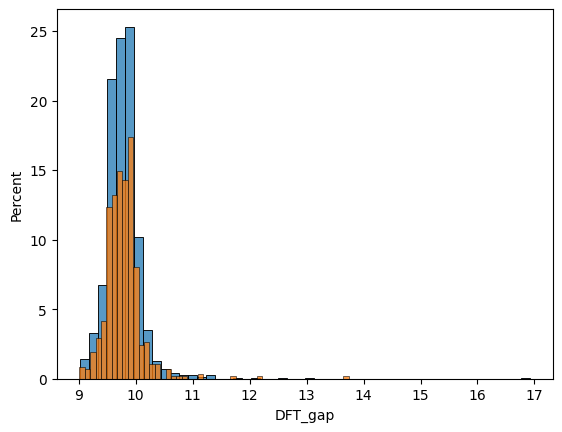

In [40]:
sns.histplot(y_train, bins=50, stat='percent')
sns.histplot(y_test, bins=50, stat='percent')

In [42]:
X_smiles_norep.shape

(2871, 40, 27, 1)

In [41]:
# need DFT evaluation for creating the dataset.

with open('./../data/trainingsets/highgap_outliergen_trans1/image.pickle', 'wb') as f:
    pickle.dump((X_smiles_norep, gen_smiles0, DFT_gap_norep), f)
    
with open('./../data/trainingsets/highgap_outliergen_trans1/image_train.pickle', 'wb') as f:
    pickle.dump((X_smiles_train, SMILES_train, y_train), f)
    
with open('./../data/trainingsets/highgap_outliergen_trans1/image_test.pickle', 'wb') as f:
    pickle.dump((X_smiles_test, SMILES_test, y_test), f)

